**Premier réseau** :   
     - Objectif : prédire si un patient est sain ou atteint de pneumonie.  
     - Architecture basée sur des couches Conv2D et MaxPooling2D pour extraire les caractéristiques des images.  
     - Entraînement sur des images brutes redimensionnées à 16x16 pixels.  
     - Validation croisée à 10 plis  
     - Classes: ['NORMAL', 'PNEUMONIA']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import collections
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers

from keras.layers import Dropout


#Wilcoxon Test
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import wilcoxon

#Utilizado para guardar modelos y cargarlos
import joblib

import shap

import cv2

#Entrenamiento
batch_size = 64
nb_classes = 2
epochs = 50
crossValidationSplit = 10

In [ ]:
def cnn_model(input_shape,nb_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Rescaling(1. / 255)(inputs)

    x = layers.Conv2D(32, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(128, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Flatten()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(nb_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

In [31]:
def charger_images_par_format_cv2(chemin):
    """
    Charge des images d'un chemin spécifique dont les noms suivent le format y_x.jpeg.
    Les images sont lues en niveaux de gris, leur taille originale est respectée, 
    et leur dimension du canal est explicitement ajoutée pour éviter toute perte d'information.
    
    Paramètres :
    chemin (str) : Chemin de base où chercher les images.
    
    Retourne :
    X (np.array) : Liste des images traitées.
    y (np.array) : Liste des labels extraits des noms des fichiers.
    input_shape (tuple) : Taille des images (hauteur, largeur, canaux).
    """
    X = []
    y = []
    dimensions = None

    # Chemin pour les images respectant le format spécifié
    chemin_images = rf'{chemin}\*_*.jpeg'

    # Parcourir toutes les images correspondant au modèle
    for fichier in glob.glob(chemin_images):
        # Lire l'image en niveaux de gris
        image = cv2.imread(fichier, cv2.IMREAD_GRAYSCALE)
        if image is not None:  # Vérifier si l'image a été correctement chargée
            # Ajouter une dimension pour le canal
            image = np.expand_dims(image, axis=-1)
            X.append(image)
            
            # Vérifier et conserver la taille de la première image
            if dimensions is None:
                hauteur, largeur = image.shape[:2]
                dimensions = (hauteur, largeur, 1)  # Ajouter explicitement le canal (gris)
            
            # Extraire le label y depuis le nom de fichier
            nom = fichier.split('\\')[-1].replace('.jpeg', '')  # Récupérer le nom sans extension
            label = int(nom.split('_')[0])  # Extraire 'y' avant le '_'
            if label == 2:
                y.append(1)
            else:
                y.append(label)
        else:
            print(f"Impossible de lire l'image : {fichier}")

    # Convertir X et y en tableaux numpy
    return np.array(X), np.array(y), dimensions




In [32]:
def plot_symbols(X,y,n=15):
    index = np.random.randint(len(y), size=n)
    plt.figure(figsize=(n, 3))
    for i in np.arange(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[index[i],:,:,0])
        plt.gray()
        ax.set_title('{}-{}'.format(y[index[i]],index[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [33]:
def enregistrer_tableau_dans_txt(tableau, nom_fichier):
    """
    Enregistre les éléments d'un tableau dans un fichier .txt.

    Args:
        tableau (list): Liste des éléments à enregistrer.
        nom_fichier (str): Nom du fichier (doit inclure l'extension .txt).
    
    Returns:
        None
    """
    try:
        # Ouvrir le fichier en mode écriture
        with open(nom_fichier, 'w', encoding='utf-8') as fichier:
            # Écrire chaque élément du tableau sur une nouvelle ligne
            for element in tableau:
                fichier.write(str(element) + '\n')
        print(f"Tableau enregistré avec succès dans '{nom_fichier}'")
    except Exception as e:
        print(f"Erreur lors de l'enregistrement du fichier : {e}")


(5832, 16, 16, 1) échantillons d'entraînement
(16, 16, 1) input_shape
50 epochs


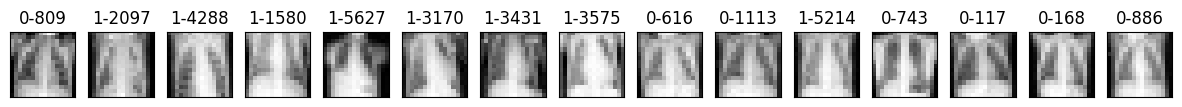

x_train (5248, 16, 16, 1) x_test (584, 16, 16, 1)
y_train (5248,) y_test (584,)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_10 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 2s - 27ms/step - accuracy: 0.7321 - loss: 0.5610 - val_accuracy: 0.8271 - val_loss: 0.3851
Epoch 2/50
82/82 - 1s - 7ms/step - accuracy: 0.8544 - loss: 0.3460 - val_accuracy: 0.8904 - val_loss: 0.2565
Epoch 3/50
82/82 - 0s - 6ms/step - accuracy: 0.8982 - loss: 0.2465 - val_accuracy: 0.9178 - val_loss: 0.2012
Epoch 4/50
82/82 - 1s - 7ms/step - accuracy: 0.9226 - loss: 0.2035 - val_accuracy: 0.9332 - val_loss: 0.1643
Epoch 5/50
82/82 - 1s - 7ms/step - accuracy: 0.9188 - loss: 0.2024 - val_accuracy: 0.9247 - val_loss: 0.1689
Epoch 6/50
82/82 - 1s - 6ms/step - accuracy: 0.9287 - loss: 0.1824 - val_accuracy: 0.9092 - val_loss: 0.2152
Epoch 7/50
82/82 - 0s - 6ms/step - accuracy: 0.9377 - loss: 0.1605 - val_accuracy: 0.9418 - val_loss: 0.1501
Epoch 8/50
82/82 - 0s - 6ms/step - accuracy: 0.9472 - loss: 0.1518 - val_accuracy: 0.9384 - val_loss: 0.1429
Epoch 9/50
82/82 - 0s - 6ms/step - accuracy: 0.9505 - loss: 0.1331 - val_accuracy: 0.9384 - val_loss: 0.1568
Epoch 10/50
8

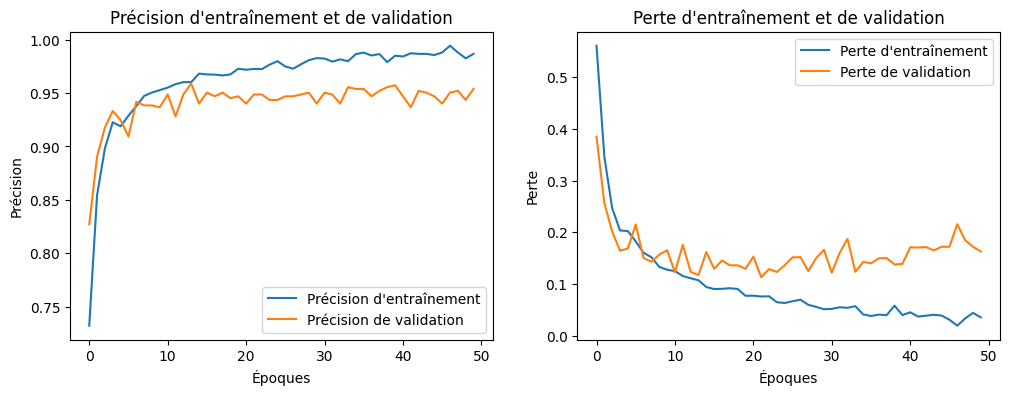

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9343 - loss: 0.2203
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 1:
perte: 0.16 précision: 0.95
AUC 0.9886
Prédictions
Counter({np.int64(1): 431, np.int64(0): 153}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.93      0.90      0.91       158
   Pneumonia       0.96      0.97      0.97       426

    accuracy                           0.95       584
   macro avg       0.95      0.94      0.94       584
weighted avg       0.95      0.95      0.95       584

Matrice de confusion


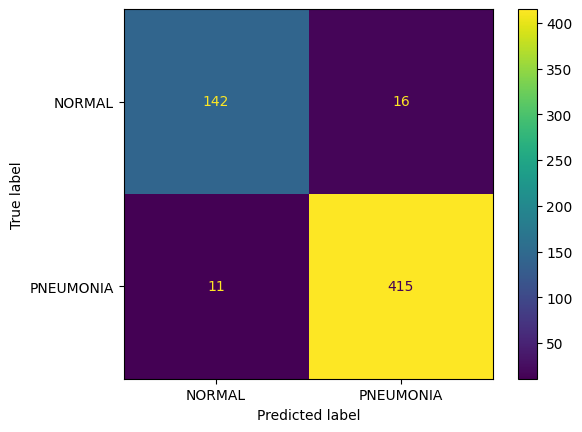

x_train (5248, 16, 16, 1) x_test (584, 16, 16, 1)
y_train (5248,) y_test (584,)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_11 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 2s - 28ms/step - accuracy: 0.7245 - loss: 0.5924 - val_accuracy: 0.7295 - val_loss: 0.5514
Epoch 2/50
82/82 - 1s - 6ms/step - accuracy: 0.8144 - loss: 0.3872 - val_accuracy: 0.8442 - val_loss: 0.3455
Epoch 3/50
82/82 - 1s - 7ms/step - accuracy: 0.9036 - loss: 0.2402 - val_accuracy: 0.9144 - val_loss: 0.2060
Epoch 4/50
82/82 - 1s - 7ms/step - accuracy: 0.9106 - loss: 0.2272 - val_accuracy: 0.9075 - val_loss: 0.2527
Epoch 5/50
82/82 - 1s - 7ms/step - accuracy: 0.9280 - loss: 0.1796 - val_accuracy: 0.9401 - val_loss: 0.1753
Epoch 6/50
82/82 - 1s - 7ms/step - accuracy: 0.9333 - loss: 0.1748 - val_accuracy: 0.9401 - val_loss: 0.1748
Epoch 7/50
82/82 - 0s - 5ms/step - accuracy: 0.9411 - loss: 0.1536 - val_accuracy: 0.9401 - val_loss: 0.1854
Epoch 8/50
82/82 - 1s - 6ms/step - accuracy: 0.9356 - loss: 0.1696 - val_accuracy: 0.9229 - val_loss: 0.1914
Epoch 9/50
82/82 - 0s - 6ms/step - accuracy: 0.9455 - loss: 0.1437 - val_accuracy: 0.9315 - val_loss: 0.1902
Epoch 10/50
8

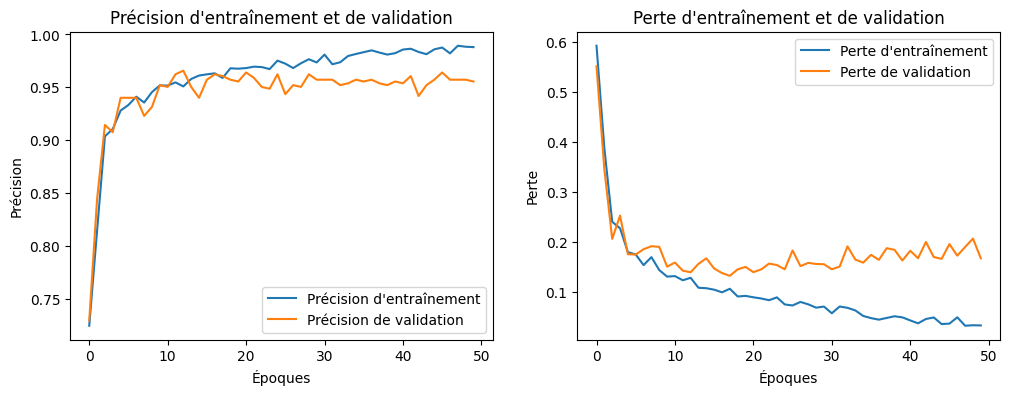

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9291 - loss: 0.2476
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 2:
perte: 0.17 précision: 0.96
AUC 0.9857
Prédictions
Counter({np.int64(1): 436, np.int64(0): 148}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.95      0.89      0.92       158
   Pneumonia       0.96      0.98      0.97       426

    accuracy                           0.96       584
   macro avg       0.95      0.93      0.94       584
weighted avg       0.96      0.96      0.96       584

Matrice de confusion


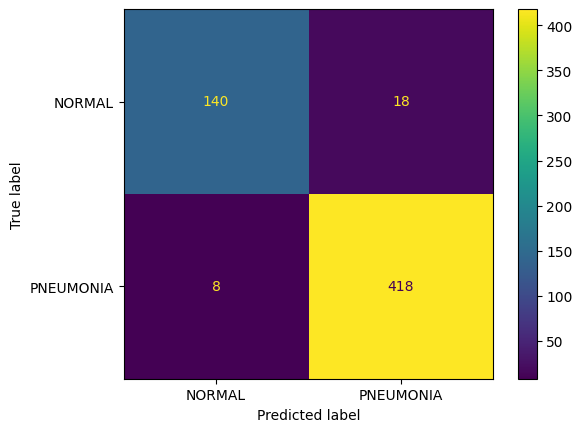

x_train (5249, 16, 16, 1) x_test (583, 16, 16, 1)
y_train (5249,) y_test (583,)


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_12 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 28ms/step - accuracy: 0.7270 - loss: 0.5712 - val_accuracy: 0.7616 - val_loss: 0.4700
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.8384 - loss: 0.3668 - val_accuracy: 0.8285 - val_loss: 0.3753
Epoch 3/50
83/83 - 1s - 7ms/step - accuracy: 0.8975 - loss: 0.2446 - val_accuracy: 0.9057 - val_loss: 0.2182
Epoch 4/50
83/83 - 1s - 7ms/step - accuracy: 0.9227 - loss: 0.2008 - val_accuracy: 0.9142 - val_loss: 0.2094
Epoch 5/50
83/83 - 1s - 6ms/step - accuracy: 0.9265 - loss: 0.1923 - val_accuracy: 0.9262 - val_loss: 0.1736
Epoch 6/50
83/83 - 1s - 6ms/step - accuracy: 0.9423 - loss: 0.1555 - val_accuracy: 0.9280 - val_loss: 0.1591
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.9442 - loss: 0.1500 - val_accuracy: 0.9331 - val_loss: 0.1671
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.9522 - loss: 0.1348 - val_accuracy: 0.9297 - val_loss: 0.1709
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.9520 - loss: 0.1325 - val_accuracy: 0.9468 - val_loss: 0.1501
Epoch 10/50
8

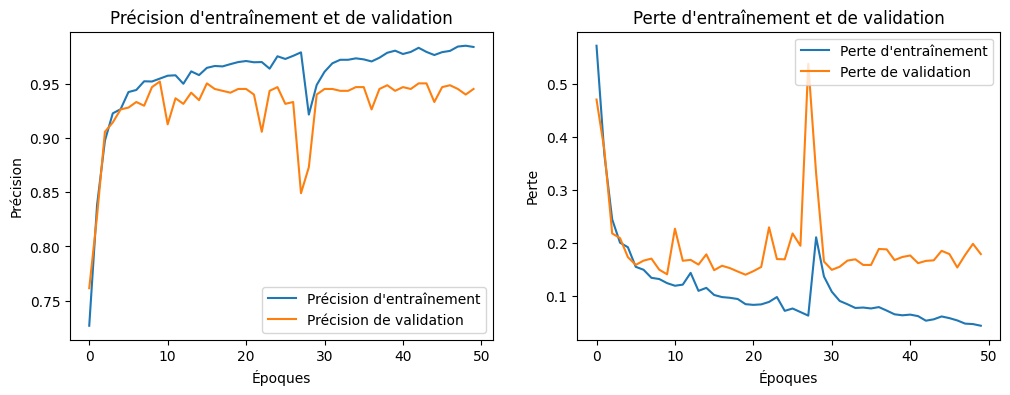

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9242 - loss: 0.2460
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 3:
perte: 0.18 précision: 0.95
AUC 0.9862
Prédictions
Counter({np.int64(1): 427, np.int64(0): 156}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.90      0.89      0.90       158
   Pneumonia       0.96      0.96      0.96       425

    accuracy                           0.95       583
   macro avg       0.93      0.93      0.93       583
weighted avg       0.94      0.95      0.95       583

Matrice de confusion


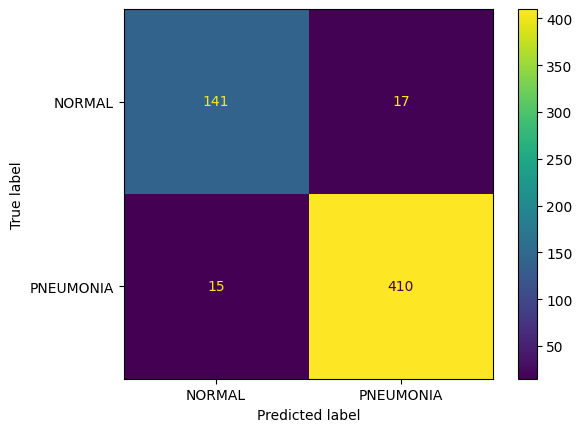

x_train (5249, 16, 16, 1) x_test (583, 16, 16, 1)
y_train (5249,) y_test (583,)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_13 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 29ms/step - accuracy: 0.7432 - loss: 0.5345 - val_accuracy: 0.8525 - val_loss: 0.3648
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.8644 - loss: 0.3159 - val_accuracy: 0.9211 - val_loss: 0.1950
Epoch 3/50
83/83 - 0s - 6ms/step - accuracy: 0.9036 - loss: 0.2416 - val_accuracy: 0.9348 - val_loss: 0.1672
Epoch 4/50
83/83 - 1s - 7ms/step - accuracy: 0.9238 - loss: 0.1957 - val_accuracy: 0.9417 - val_loss: 0.1607
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.9339 - loss: 0.1791 - val_accuracy: 0.9451 - val_loss: 0.1569
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.9307 - loss: 0.1763 - val_accuracy: 0.9365 - val_loss: 0.1471
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.9448 - loss: 0.1518 - val_accuracy: 0.9640 - val_loss: 0.1256
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.9467 - loss: 0.1436 - val_accuracy: 0.9417 - val_loss: 0.1511
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.9390 - loss: 0.1602 - val_accuracy: 0.9365 - val_loss: 0.1662
Epoch 10/50
8

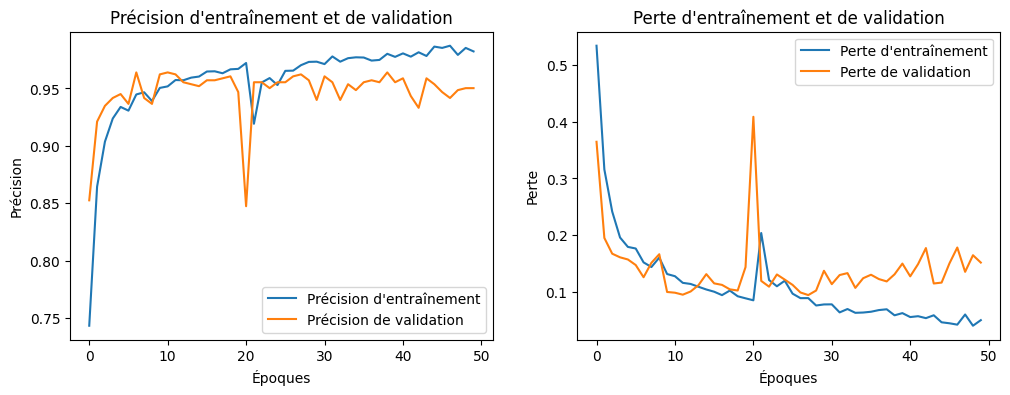

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9156 - loss: 0.2708 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 4:
perte: 0.15 précision: 0.95
AUC 0.9897
Prédictions
Counter({np.int64(1): 442, np.int64(0): 141}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.96      0.85      0.90       158
   Pneumonia       0.95      0.99      0.97       425

    accuracy                           0.95       583
   macro avg       0.95      0.92      0.93       583
weighted avg       0.95      0.95      0.95       583

Matrice de confusion


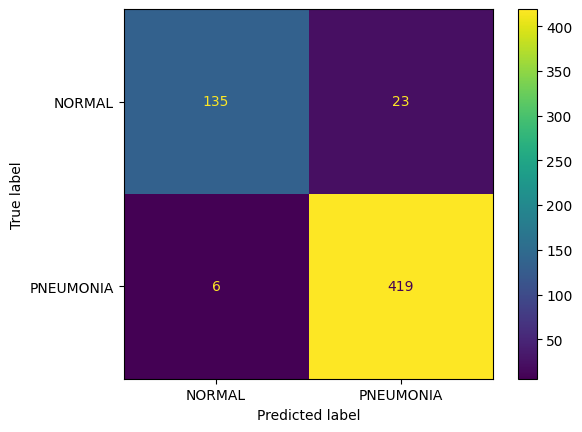

x_train (5249, 16, 16, 1) x_test (583, 16, 16, 1)
y_train (5249,) y_test (583,)


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_14 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 28ms/step - accuracy: 0.7247 - loss: 0.5739 - val_accuracy: 0.8405 - val_loss: 0.4265
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.8544 - loss: 0.3313 - val_accuracy: 0.8971 - val_loss: 0.2400
Epoch 3/50
83/83 - 1s - 7ms/step - accuracy: 0.8880 - loss: 0.2830 - val_accuracy: 0.9211 - val_loss: 0.1900
Epoch 4/50
83/83 - 1s - 7ms/step - accuracy: 0.9112 - loss: 0.2215 - val_accuracy: 0.8370 - val_loss: 0.4155
Epoch 5/50
83/83 - 1s - 7ms/step - accuracy: 0.9196 - loss: 0.2074 - val_accuracy: 0.8851 - val_loss: 0.2553
Epoch 6/50
83/83 - 1s - 7ms/step - accuracy: 0.9316 - loss: 0.1804 - val_accuracy: 0.9468 - val_loss: 0.1422
Epoch 7/50
83/83 - 1s - 7ms/step - accuracy: 0.9358 - loss: 0.1699 - val_accuracy: 0.9451 - val_loss: 0.1371
Epoch 8/50
83/83 - 1s - 7ms/step - accuracy: 0.9413 - loss: 0.1528 - val_accuracy: 0.8902 - val_loss: 0.2738
Epoch 9/50
83/83 - 1s - 7ms/step - accuracy: 0.9084 - loss: 0.2434 - val_accuracy: 0.9451 - val_loss: 0.1553
Epoch 10/50
8

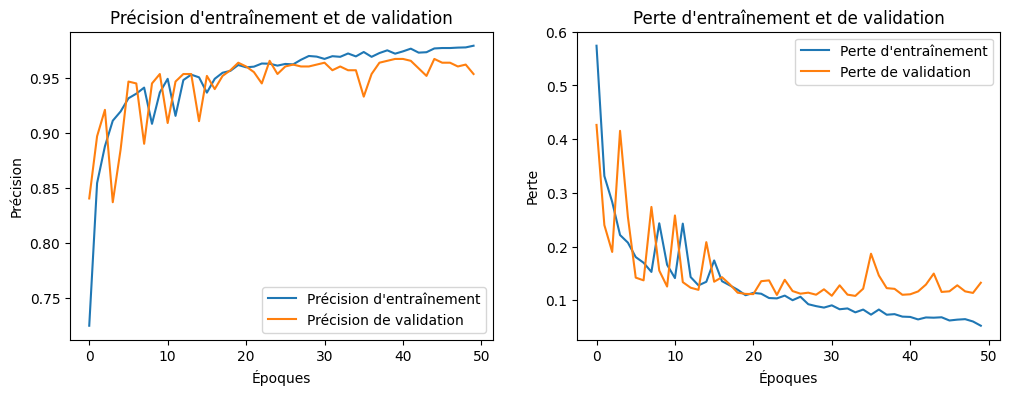

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9513 - loss: 0.1328 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 5:
perte: 0.13 précision: 0.95
AUC 0.9906
Prédictions
Counter({np.int64(1): 418, np.int64(0): 165}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.90      0.94      0.92       158
   Pneumonia       0.98      0.96      0.97       425

    accuracy                           0.95       583
   macro avg       0.94      0.95      0.94       583
weighted avg       0.95      0.95      0.95       583

Matrice de confusion


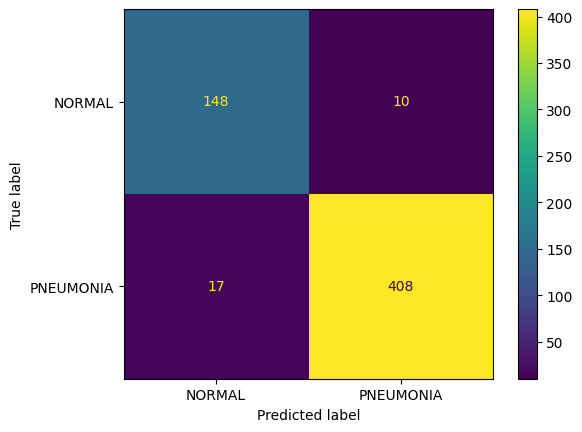

x_train (5249, 16, 16, 1) x_test (583, 16, 16, 1)
y_train (5249,) y_test (583,)


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_15 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 28ms/step - accuracy: 0.7283 - loss: 0.5843 - val_accuracy: 0.7307 - val_loss: 0.5565
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.8203 - loss: 0.3896 - val_accuracy: 0.8113 - val_loss: 0.4619
Epoch 3/50
83/83 - 1s - 7ms/step - accuracy: 0.8893 - loss: 0.2763 - val_accuracy: 0.9331 - val_loss: 0.2048
Epoch 4/50
83/83 - 0s - 6ms/step - accuracy: 0.9143 - loss: 0.2216 - val_accuracy: 0.8954 - val_loss: 0.2769
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.9152 - loss: 0.2133 - val_accuracy: 0.9262 - val_loss: 0.1826
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.9320 - loss: 0.1782 - val_accuracy: 0.9348 - val_loss: 0.1718
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.9297 - loss: 0.1891 - val_accuracy: 0.9503 - val_loss: 0.1412
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.9434 - loss: 0.1516 - val_accuracy: 0.9503 - val_loss: 0.1359
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.9484 - loss: 0.1408 - val_accuracy: 0.9451 - val_loss: 0.1358
Epoch 10/50
8

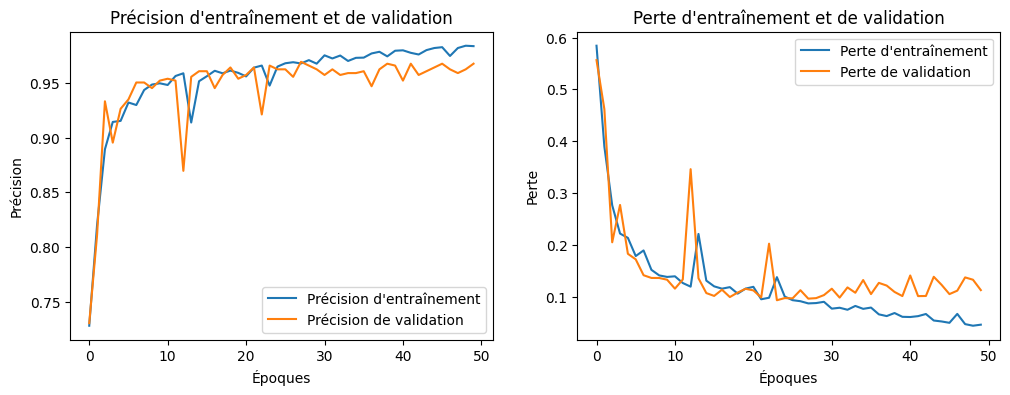

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9564 - loss: 0.1293 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 6:
perte: 0.11 précision: 0.97
AUC 0.9932
Prédictions
Counter({np.int64(1): 425, np.int64(0): 158}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.94      0.94      0.94       157
   Pneumonia       0.98      0.98      0.98       426

    accuracy                           0.97       583
   macro avg       0.96      0.96      0.96       583
weighted avg       0.97      0.97      0.97       583

Matrice de confusion


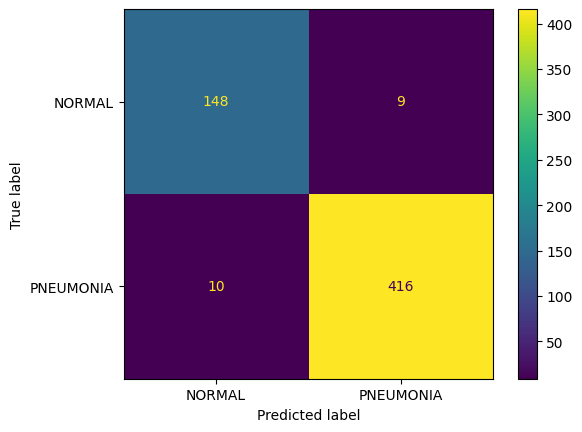

x_train (5249, 16, 16, 1) x_test (583, 16, 16, 1)
y_train (5249,) y_test (583,)


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_16 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 33ms/step - accuracy: 0.7266 - loss: 0.5738 - val_accuracy: 0.7341 - val_loss: 0.4428
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.8371 - loss: 0.3665 - val_accuracy: 0.8645 - val_loss: 0.3110
Epoch 3/50
83/83 - 1s - 7ms/step - accuracy: 0.8849 - loss: 0.2774 - val_accuracy: 0.8405 - val_loss: 0.3566
Epoch 4/50
83/83 - 1s - 7ms/step - accuracy: 0.8935 - loss: 0.2595 - val_accuracy: 0.9177 - val_loss: 0.2090
Epoch 5/50
83/83 - 1s - 6ms/step - accuracy: 0.9209 - loss: 0.2003 - val_accuracy: 0.9194 - val_loss: 0.1991
Epoch 6/50
83/83 - 1s - 6ms/step - accuracy: 0.9316 - loss: 0.1807 - val_accuracy: 0.9211 - val_loss: 0.1809
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.9358 - loss: 0.1708 - val_accuracy: 0.9314 - val_loss: 0.1783
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.9444 - loss: 0.1591 - val_accuracy: 0.9245 - val_loss: 0.1818
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.9413 - loss: 0.1569 - val_accuracy: 0.9262 - val_loss: 0.1705
Epoch 10/50
8

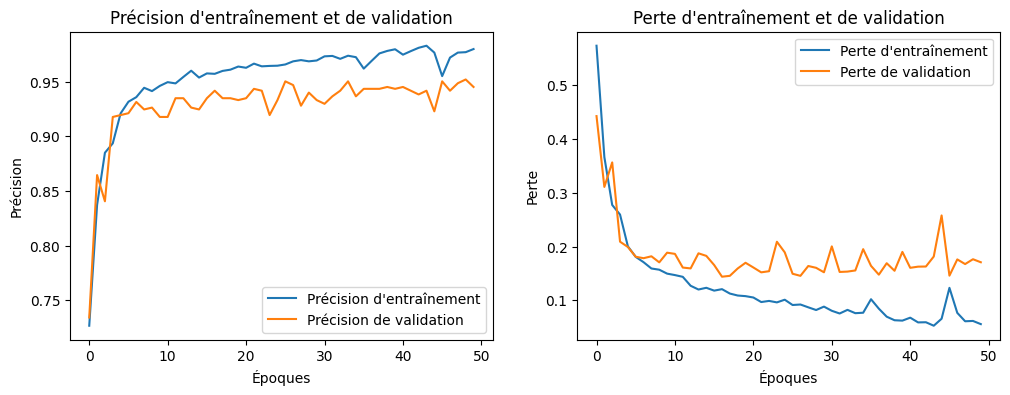

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9279 - loss: 0.2196
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 7:
perte: 0.17 précision: 0.95
AUC 0.9842
Prédictions
Counter({np.int64(1): 432, np.int64(0): 151}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.91      0.88      0.90       157
   Pneumonia       0.96      0.97      0.96       426

    accuracy                           0.95       583
   macro avg       0.93      0.92      0.93       583
weighted avg       0.94      0.95      0.94       583

Matrice de confusion


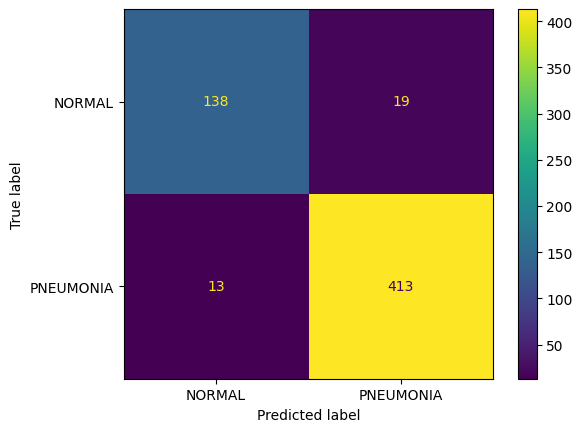

x_train (5249, 16, 16, 1) x_test (583, 16, 16, 1)
y_train (5249,) y_test (583,)


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_17 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 3s - 31ms/step - accuracy: 0.7291 - loss: 0.5602 - val_accuracy: 0.7719 - val_loss: 0.4514
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.8644 - loss: 0.3260 - val_accuracy: 0.8542 - val_loss: 0.4062
Epoch 3/50
83/83 - 1s - 6ms/step - accuracy: 0.8821 - loss: 0.2769 - val_accuracy: 0.9211 - val_loss: 0.2227
Epoch 4/50
83/83 - 1s - 6ms/step - accuracy: 0.9093 - loss: 0.2294 - val_accuracy: 0.9194 - val_loss: 0.2150
Epoch 5/50
83/83 - 1s - 6ms/step - accuracy: 0.9211 - loss: 0.2042 - val_accuracy: 0.7547 - val_loss: 0.5606
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.8706 - loss: 0.3004 - val_accuracy: 0.9365 - val_loss: 0.2008
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.9225 - loss: 0.1945 - val_accuracy: 0.9365 - val_loss: 0.1903
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.9331 - loss: 0.1722 - val_accuracy: 0.9365 - val_loss: 0.1752
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.9322 - loss: 0.1752 - val_accuracy: 0.9365 - val_loss: 0.1723
Epoch 10/50
8

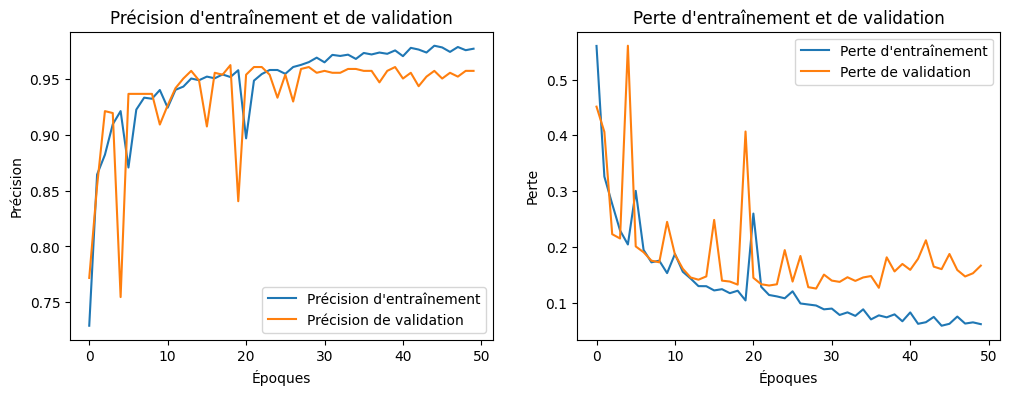

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9228 - loss: 0.3051 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Partition numéro 8:
perte: 0.17 précision: 0.96
AUC 0.9845
Prédictions
Counter({np.int64(1): 439, np.int64(0): 144}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.96      0.88      0.92       157
   Pneumonia       0.96      0.99      0.97       426

    accuracy                           0.96       583
   macro avg       0.96      0.93      0.94       583
weighted avg       0.96      0.96      0.96       583

Matrice de confusion


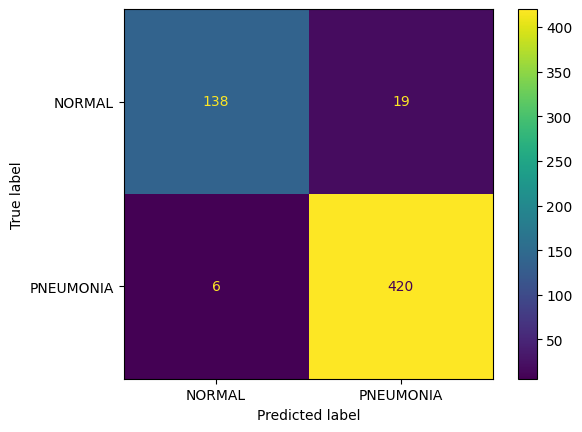

x_train (5249, 16, 16, 1) x_test (583, 16, 16, 1)
y_train (5249,) y_test (583,)


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_18 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 30ms/step - accuracy: 0.7300 - loss: 0.5619 - val_accuracy: 0.8456 - val_loss: 0.4023
Epoch 2/50
83/83 - 0s - 6ms/step - accuracy: 0.8625 - loss: 0.3247 - val_accuracy: 0.8971 - val_loss: 0.2583
Epoch 3/50
83/83 - 0s - 6ms/step - accuracy: 0.9021 - loss: 0.2418 - val_accuracy: 0.9142 - val_loss: 0.2018
Epoch 4/50
83/83 - 1s - 6ms/step - accuracy: 0.9253 - loss: 0.1954 - val_accuracy: 0.9125 - val_loss: 0.2495
Epoch 5/50
83/83 - 1s - 6ms/step - accuracy: 0.9293 - loss: 0.1804 - val_accuracy: 0.9280 - val_loss: 0.1726
Epoch 6/50
83/83 - 1s - 6ms/step - accuracy: 0.9387 - loss: 0.1626 - val_accuracy: 0.9057 - val_loss: 0.2411
Epoch 7/50
83/83 - 1s - 6ms/step - accuracy: 0.9411 - loss: 0.1554 - val_accuracy: 0.9365 - val_loss: 0.1512
Epoch 8/50
83/83 - 1s - 7ms/step - accuracy: 0.9472 - loss: 0.1420 - val_accuracy: 0.9348 - val_loss: 0.1557
Epoch 9/50
83/83 - 1s - 7ms/step - accuracy: 0.9493 - loss: 0.1386 - val_accuracy: 0.9331 - val_loss: 0.1852
Epoch 10/50
8

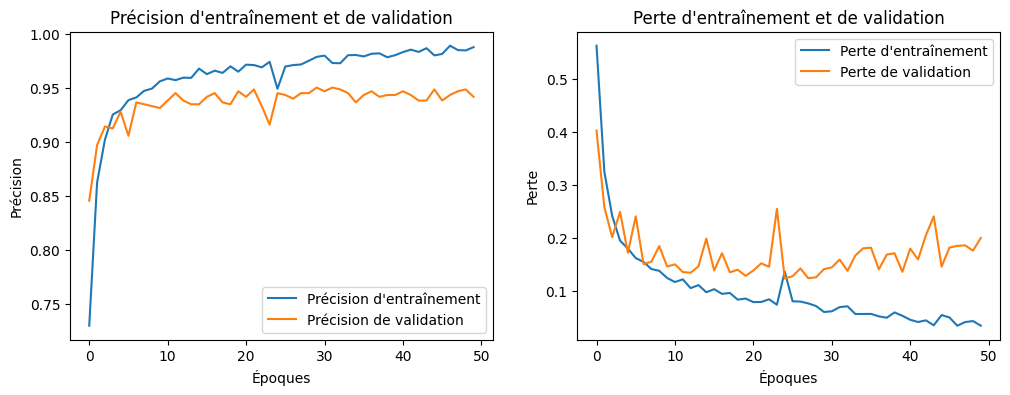

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9426 - loss: 0.1895
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 9:
perte: 0.20 précision: 0.94
AUC 0.9884
Prédictions
Counter({np.int64(1): 414, np.int64(0): 169}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.86      0.93      0.90       157
   Pneumonia       0.97      0.95      0.96       426

    accuracy                           0.94       583
   macro avg       0.92      0.94      0.93       583
weighted avg       0.94      0.94      0.94       583

Matrice de confusion


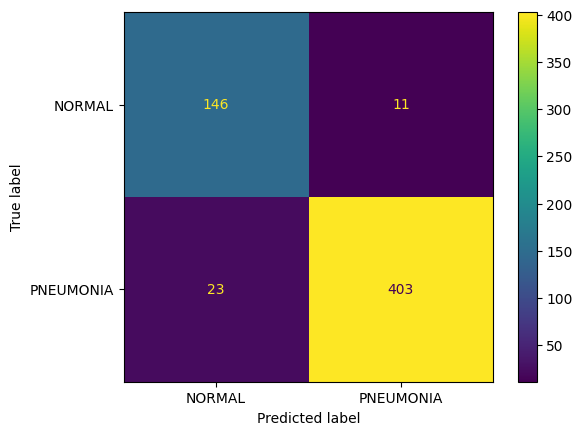

x_train (5249, 16, 16, 1) x_test (583, 16, 16, 1)
y_train (5249,) y_test (583,)


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_19 (Rescaling)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 15, 15, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 6, 6, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 2, 2, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,490 (419.88 KB)

 Trainable params: 107,490 (419.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
83/83 - 2s - 29ms/step - accuracy: 0.7272 - loss: 0.5867 - val_accuracy: 0.7307 - val_loss: 0.5530
Epoch 2/50
83/83 - 1s - 7ms/step - accuracy: 0.8327 - loss: 0.3672 - val_accuracy: 0.8576 - val_loss: 0.3443
Epoch 3/50
83/83 - 1s - 7ms/step - accuracy: 0.8927 - loss: 0.2571 - val_accuracy: 0.8148 - val_loss: 0.5409
Epoch 4/50
83/83 - 1s - 6ms/step - accuracy: 0.8905 - loss: 0.2892 - val_accuracy: 0.8559 - val_loss: 0.3560
Epoch 5/50
83/83 - 0s - 6ms/step - accuracy: 0.8988 - loss: 0.2718 - val_accuracy: 0.9331 - val_loss: 0.1686
Epoch 6/50
83/83 - 0s - 6ms/step - accuracy: 0.9305 - loss: 0.1797 - val_accuracy: 0.9417 - val_loss: 0.1546
Epoch 7/50
83/83 - 0s - 6ms/step - accuracy: 0.9350 - loss: 0.1687 - val_accuracy: 0.9434 - val_loss: 0.1513
Epoch 8/50
83/83 - 0s - 6ms/step - accuracy: 0.9415 - loss: 0.1591 - val_accuracy: 0.9417 - val_loss: 0.1451
Epoch 9/50
83/83 - 0s - 6ms/step - accuracy: 0.9427 - loss: 0.1471 - val_accuracy: 0.9468 - val_loss: 0.1372
Epoch 10/50
8

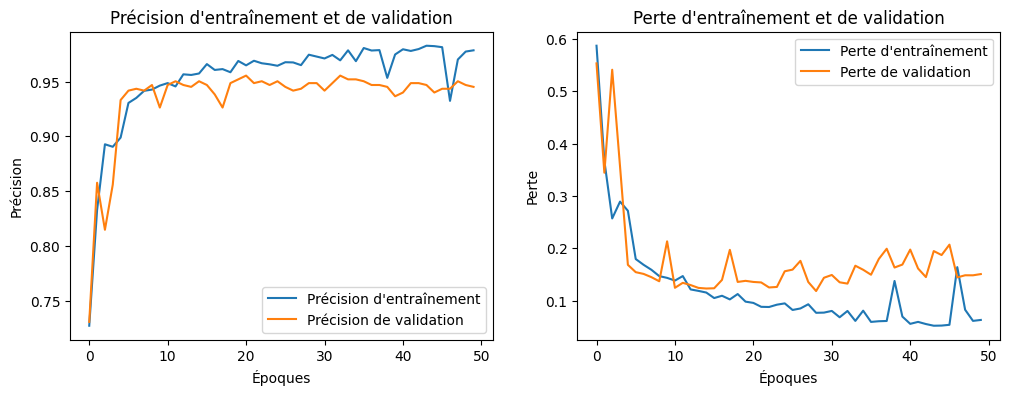

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9138 - loss: 0.2215
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Partition numéro 10:
perte: 0.15 précision: 0.95
AUC 0.9888
Prédictions
Counter({np.int64(1): 438, np.int64(0): 145}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.93      0.86      0.89       157
   Pneumonia       0.95      0.98      0.96       426

    accuracy                           0.95       583
   macro avg       0.94      0.92      0.93       583
weighted avg       0.94      0.95      0.94       583

Matrice de confusion


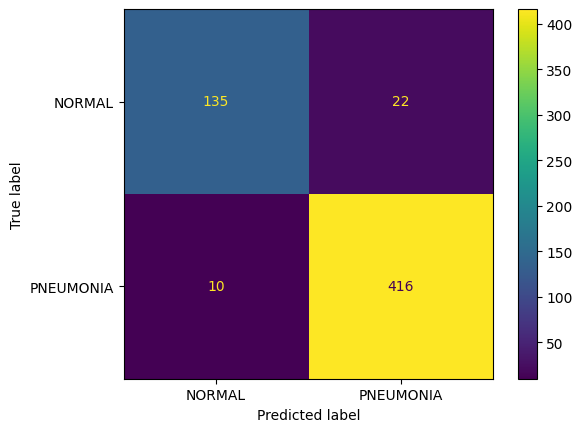

Le meilleur modèle a été sauvegardé avec un ROC de: 0.9931670703627284
Fin de l'entraînement
Résultats ROC:
0.9885749093718429

0.9856926368336603

0.9862099776619508

0.9896798212956068

0.9905584512285927

0.9931670703627284

0.984210998474926

0.9844801291827397

0.9883974761520289

0.98878622050776

Tableau enregistré avec succès dans 'resultatsROC_1_1.txt'


In [34]:
def main(path): 
    resultatsROC = []
    
    X, y, input_shape = charger_images_par_format_cv2(path)

    print(X.shape, 'échantillons d\'entraînement')  # Traducción: train samples
    print(input_shape,'input_shape')
    print(epochs,'epochs')

    plot_symbols(X, y)
    collections.Counter(y)

    # CV-10
    kf = StratifiedKFold(n_splits=crossValidationSplit, shuffle=True, random_state=123)

    splitEntrenamiento = 1
    meilleur_roc = -1  # Para almacenar el mejor valor de ROC
    meilleur_modele = None  # Para guardar el mejor modelo

    #90% train | 10% test
    for train_index, test_index in kf.split(X, y):
        # Division des données en ensemble d'entraînement et de test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Informations sur les dimensions des données
        print(f'x_train {X_train.shape} x_test {X_test.shape}')
        print(f'y_train {y_train.shape} y_test {y_test.shape}')

        # Création du modèle
        model = cnn_model(input_shape, nb_classes)
        print(model.summary())

        # Compilation du modèle
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Entraînement du modèle directement avec les données
        history = model.fit(X_train, y_train, 
            batch_size=batch_size, 
            epochs=epochs, 
            validation_data=(X_test, y_test), 
            verbose=2)


        # Obtener las métricas del historial
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        # Graficar la precisión
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(acc, label='Précision d\'entraînement')  # Traducción: Training Accuracy
        plt.plot(val_acc, label='Précision de validation')  # Traducción: Validation Accuracy
        plt.legend()
        plt.title('Précision d\'entraînement et de validation')  # Traducción: Training and Validation Accuracy
        plt.xlabel('Époques')  # Traducción: Epochs
        plt.ylabel('Précision')  # Traducción: Accuracy

        # Graficar la pérdida
        plt.subplot(1, 2, 2)
        plt.plot(loss, label='Perte d\'entraînement')  # Traducción: Training Loss
        plt.plot(val_loss, label='Perte de validation')  # Traducción: Validation Loss
        plt.legend()
        plt.title('Perte d\'entraînement et de validation')  # Traducción: Training and Validation Loss
        plt.xlabel('Époques')  # Traducción: Epochs
        plt.ylabel('Perte')  # Traducción: Loss

        plt.show()

        # Visualizar datos del split
        loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
        y_pred = model.predict(X_test)

        # Guardar datos ROC
        roc = roc_auc_score(y_test, y_pred[:, 1])
        resultatsROC.append(roc)

        # Guardar el mejor modelo
        if roc > meilleur_roc:
            meilleur_roc = roc
            meilleur_modele = model

        # Graficas sobre Test
        print(f"Partition numéro {splitEntrenamiento}:")  # Traducción: Split número
        print(f'perte: {loss:.2f} précision: {acc:.2f}')  # Traducción: loss, acc
        print(f'AUC {roc:.4f}')

        print('Prédictions')  # Traducción: Predictions
        y_pred_int = y_pred.argmax(axis=1)
        print(collections.Counter(y_pred_int), '\n')

        print('Métriques')  # Traducción: Metrics
        print(metrics.classification_report(y_test, y_pred_int, target_names=['Normal', 'Pneumonia']))

        print('Matrice de confusion')  # Traducción: Confusion matrix
        metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, y_pred_int),
                                       display_labels=['NORMAL', 'PNEUMONIA']).plot()
        plt.show()

        splitEntrenamiento += 1

    # Guardar el mejor modelo
    if meilleur_modele:
        meilleur_modele.save(r"..\models\meilleur_modele_roc_1_1.h5")
        print("Le meilleur modèle a été sauvegardé avec un ROC de:", meilleur_roc)  # Traducción: El mejor modelo fue guardado con un ROC de.

    print("Fin de l\'entraînement")  # Traducción: Fin de entrenamiento
    
    print("Résultats ROC:")  # Traducción: Resultados ROC
    for r in resultatsROC:
        print(f"{r}\n")
        
    enregistrer_tableau_dans_txt(resultatsROC, "resultatsROC_1_1.txt")

if __name__ == '__main__':
    path_save_16x16=r"..\data\processed\images_16x16"
    main(path_save_16x16)
